In [135]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from src.data_processing import process_file, compute_physical, process_file_from_wizard

folder_path = "data/Test_XH430W350_20240209/PWM_control/*.csv"

# List to store each processed dataframe
processed_dataframes = []

# Iterate over all CSV files in the folder
for file_path in glob.glob(folder_path):
    # Apply processing function to the dataframe
    processed_df = process_file_from_wizard(file_path)
    
    # Store the processed dataframe in the list
    processed_dataframes.append(processed_df)

external_inertia = 0.0022421143208 # Msolo
Ra = 9.3756 # [Ohm]
k_t = 2.6657

In [136]:
from src.data_processing import split_experiments

# Assuming processed_dataframes is your list of dataframes
all_experiments_with_transients = []
for df in processed_dataframes:
    experiments_with_transients = split_experiments(df)
    all_experiments_with_transients.extend(experiments_with_transients)

# Now, all_experiments_with_transients includes each experiment with 10 samples before the start, if available

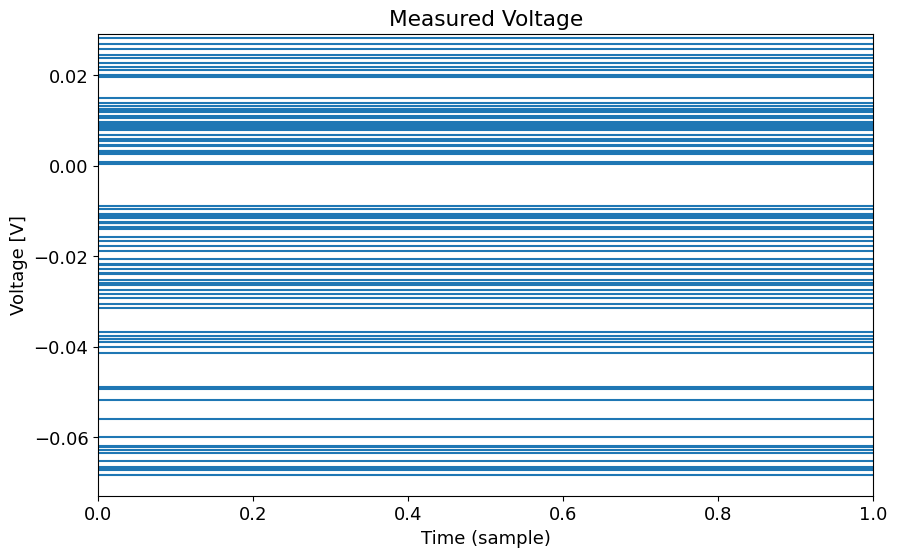

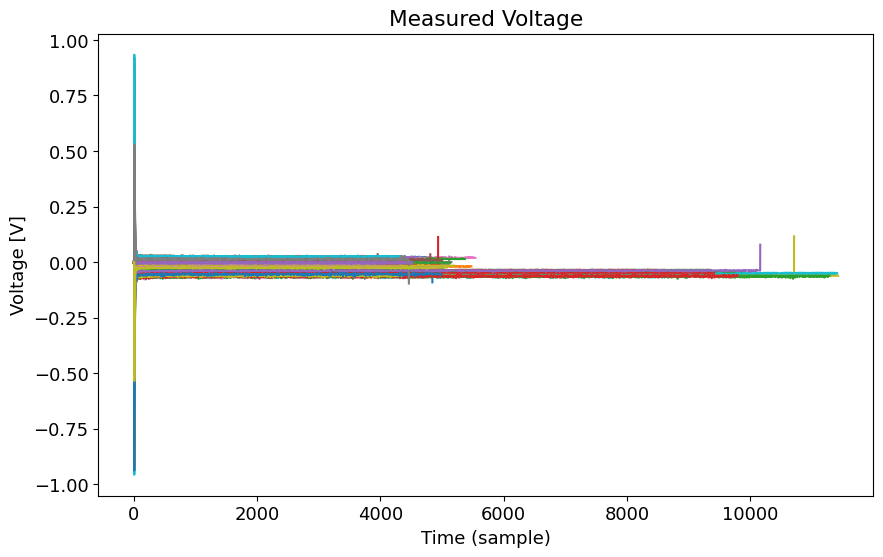

In [137]:
plt.figure(figsize=(10, 6))
count = 0
all_experiment = all_experiments_with_transients
for df in all_experiment:
    if abs(df['U'].mean()) > 1.51:
        # plt.plot(df['U'])
        # plt.plot(df['DXL_Current'])
        plt.axhline(df['DXL_Current'].mean())
        count += 1

plt.xlabel('Time (sample)')
plt.ylabel('Voltage [V]')
plt.title(f'Measured Voltage')
plt.show()

plt.figure(figsize=(10, 6))
count = 0
for df in all_experiment:
    plt.plot(df['DXL_Current'])
    count += 1

plt.xlabel('Time (sample)')
plt.ylabel('Voltage [V]')
plt.title(f'Measured Voltage')
plt.show()

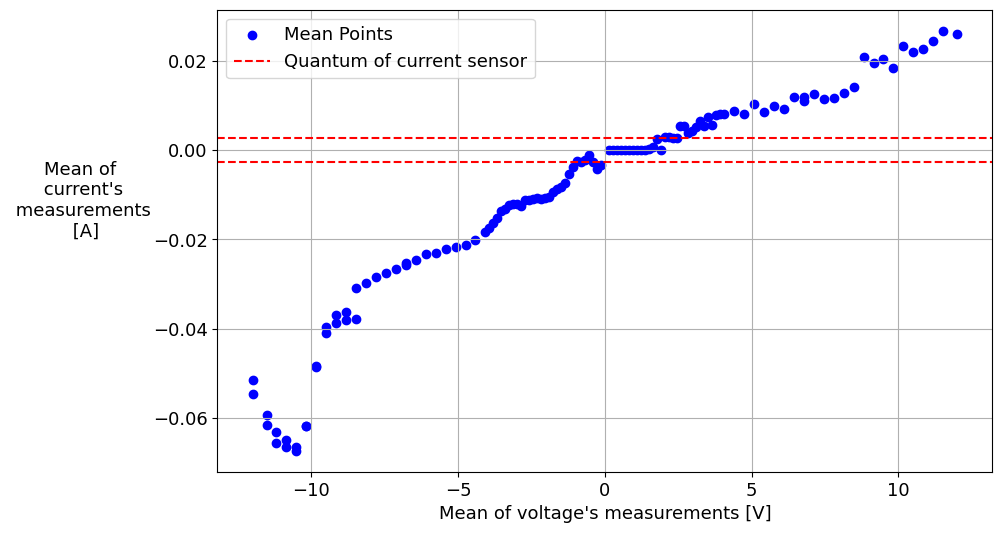

In [150]:
# Lists to hold mean values
mean_U = []
mean_DXL_Current = []

# Calculate means
for df in all_experiment:
    df = df[80:]
    if df['U'].mean() < 2 and df['U'].mean() > -0.7 :
        #pass
        mean_U.append(df['U'].mean())
        mean_DXL_Current.append(df['DXL_Current'].mean())
    else:
        mean_U.append(df['U'].mean())
        mean_DXL_Current.append(df['DXL_Current'].mean())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(mean_U, mean_DXL_Current, color='blue', label='Mean Points')
plt.axhline(2.69e-3, linestyle='--', color="red", label="Quantum of current sensor")
plt.axhline(-2.69e-3, linestyle='--', color="red")
plt.xlabel("Mean of voltage's measurements [V]")
plt.ylabel("Mean of \n current's \n measurements \n [A]", labelpad=50, rotation=0)
# plt.title('Scatter Plot of Mean U vs Mean DXL_Current')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming processed_dataframes is your list of dataframes

# Combine all filtered dataframes where 'U' is not 0 into a single dataframe
all_data = pd.DataFrame()
for df in processed_dataframes:
    filtered_df = df[df['U'] != 0]
    all_data = pd.concat([all_data, filtered_df], ignore_index=True)

# Create a density heatmap using seaborn's kdeplot
plt.figure(figsize=(10, 7))
sns.kdeplot(data=all_data, x='DXL_Velocity', y='U', fill=True, thresh=0, levels=100, cmap="viridis")

plt.title('Density Heatmap of U vs. DXL_Velocity (U != 0)')
plt.xlabel('DXL_Velocity')
plt.ylabel('U')
plt.show()

/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_77865/186202585.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['real_velocity'] = (exp['DXL_Position'].iloc[-1] - exp['DXL_Position'].iloc[0]) / (exp['t'].iloc[-1] - exp['t'].iloc[0])
/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_77865/186202585.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['real_velocity'] = (exp['DXL_Position'].iloc[-1] - exp['DXL_Position'].iloc[0]) / (exp['t'].iloc[-1] - exp['t'].iloc[0])
/var/fol

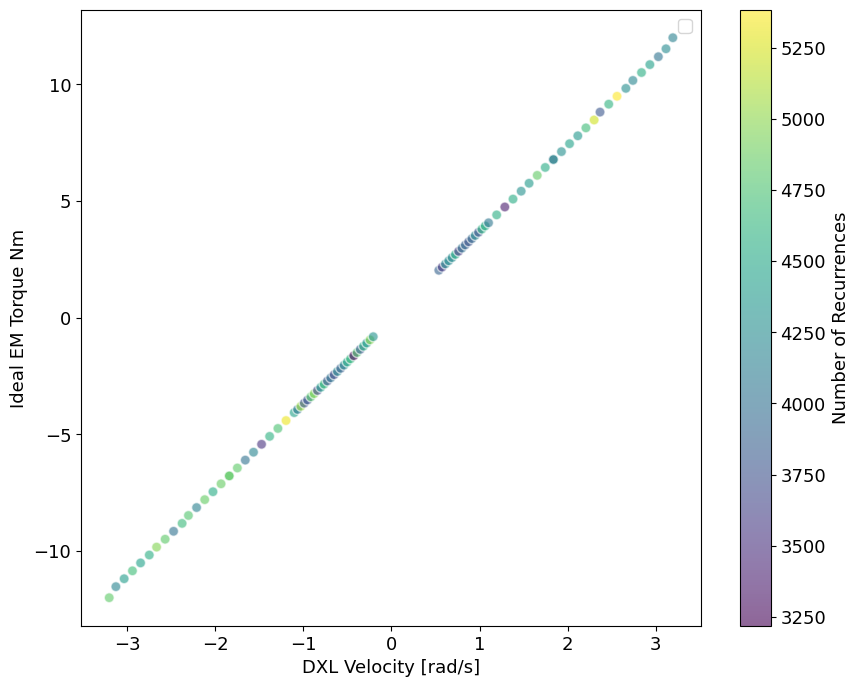

In [130]:
exps = []
for exp in all_experiments_with_transients:
    if exp['U'].mean() < 2 and exp['U'].mean() > -0.7 :
        pass
    else :
        exp = exp[80:]
        exp['real_velocity'] = (exp['DXL_Position'].iloc[-1] - exp['DXL_Position'].iloc[0]) / (exp['t'].iloc[-1] - exp['t'].iloc[0])
        exps.append(exp[80:])

big_df = pd.concat(exps, ignore_index=True)

# Group the data by 'DXL_Velocity', 'DXL_Current', and 'U' to find the recurrence
grouped = big_df.groupby(['real_velocity', 'U']).size().reset_index(name='counts')
# mean_R = grouped['R'].mean()

# Now let's create the scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(grouped['real_velocity'], grouped['U'], c=grouped['counts'], cmap='viridis', alpha=0.6, edgecolors='w', s=50)

# plt.axhline(y=mean_R, color='r', linestyle='-', label=f'Average Current: {mean_R:.2f}')


plt.xlabel('DXL Velocity [rad/s]')
plt.ylabel('Ideal EM Torque Nm')
# plt.ylabel('kphi value [V.s/rad]')
cb = plt.colorbar(sc)
cb.set_label('Number of Recurrences')
# Adding the legend
plt.legend()
plt.show()

3.6708236312126874


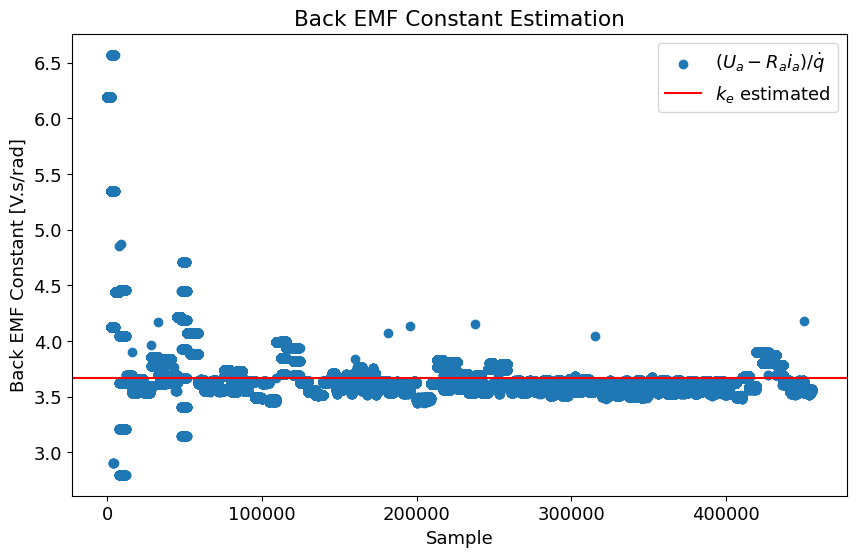

In [109]:
Ra = 9.3756 # [Ohm]
big_df['ke'] = (big_df['U'] - Ra * big_df['DXL_Current']) / big_df['real_velocity']
new_df = big_df[big_df['ke'] < 100]
neww_df = new_df[new_df['ke'] > -100]
print(neww_df['ke'].mean())
plt.figure(figsize=(10, 6))
plt.scatter(neww_df.index, neww_df['ke'], label = r"$(U_a - R_a i_a)/\dot{q}$")

plt.axhline(y=neww_df['ke'].mean(), color='r', label=r'$k_e$ estimated')
plt.xlabel('Sample')
plt.ylabel('Back EMF Constant [V.s/rad]')
plt.title(f'Back EMF Constant Estimation')
plt.legend()
plt.show()

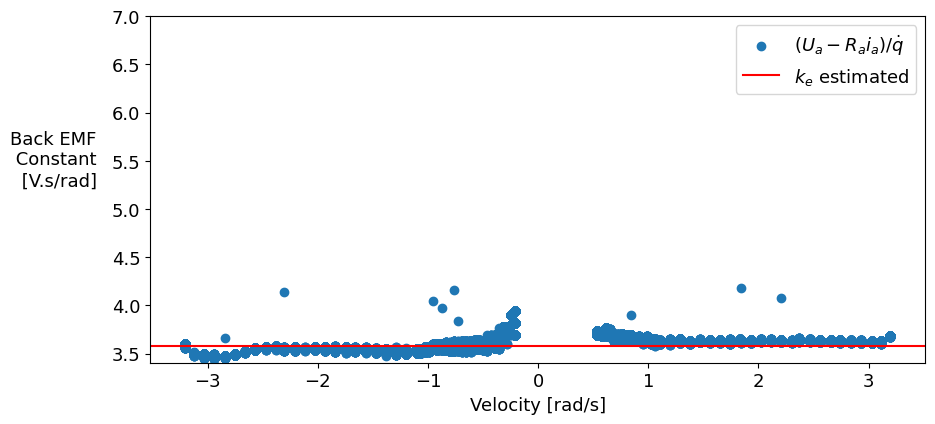

3.5899154021989697
-0.0032802856238116724
3.5831441716639625
3.5865297869314663


In [131]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import matplotlib as mpl

# Set the font size globally
mpl.rcParams.update({'font.size': 13})  # Change 14 to your desired font size


Ra = 9.3756 # [Ohm]

big_df['ke'] = (big_df['U'] - Ra * big_df['DXL_Current']) / big_df['real_velocity']
new_df = big_df[big_df['ke'] < 100]
neww_df = new_df[new_df['ke'] > -100]

my_df = neww_df[abs(neww_df['real_velocity']) > 1]
# Calculate linear regression
slope, intercept, r_value, p_value, std_err = linregress(abs(my_df['real_velocity']), my_df['ke'])

# Plotting
plt.figure(figsize=(10, 4.5))
plt.scatter(neww_df['real_velocity'], neww_df['ke'], label=r"$(U_a - R_a i_a)/\dot{q}$")

# Plot linear regression line
x = np.array(neww_df['real_velocity'])
# plt.plot(x, intercept + slope*x, 'r', label=r'$k_e$ linear regression')
plt.axhline(y=my_df['ke'].mean(), color='r', label=r'$k_e$ estimated')


plt.xlabel('Velocity [rad/s]')
plt.ylabel('Back EMF \n Constant \n [V.s/rad]', rotation=0, labelpad=40)
plt.ylim(top=7)
# plt.title('Back EMF Constant Estimation')
plt.legend()
plt.show()
print(intercept)
print(slope)
print(my_df['ke'].mean())
print((my_df['ke'].mean()+intercept)/2)

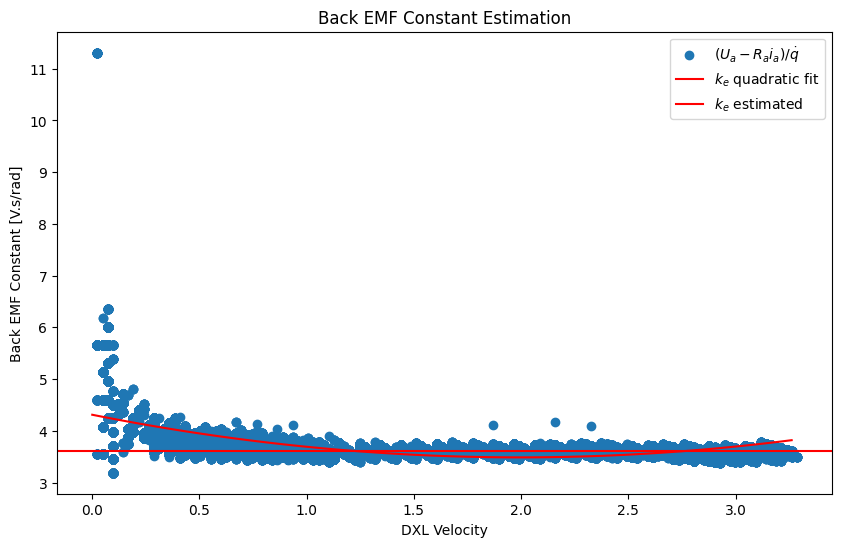

Quadratic coefficient (a): 0.2070882988616274
Linear coefficient (b): -0.8261735368418486
Intercept (c): 4.309984415094031


In [76]:
import matplotlib.pyplot as plt
import numpy as np

Ra = 9.3756 # [Ohm]
big_df['ke'] = (big_df['U'] - Ra * big_df['DXL_Current']) / big_df['DXL_Velocity']
new_df = big_df[big_df['ke'] < 100]
neww_df = new_df[new_df['ke'] > -100]

# Fit a second-order polynomial
coefficients = np.polyfit(abs(neww_df['DXL_Velocity']), neww_df['ke'], 2)

# Generate a polynomial function from the coefficients
p = np.poly1d(coefficients)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(abs(neww_df['DXL_Velocity']), neww_df['ke'], label=r"$(U_a - R_a i_a)/\dot{q}$")

# Generate x values for the polynomial line
# x = np.linspace(min(neww_df['DXL_Velocity']), max(neww_df['DXL_Velocity']), 100)
x = np.linspace(0, max(neww_df['DXL_Velocity']), 100)

plt.plot(x, p(x), 'r', label=r'$k_e$ quadratic fit')
plt.axhline(y=my_df['ke'].mean(), color='r', label=r'$k_e$ estimated')

plt.xlabel('DXL Velocity')
plt.ylabel('Back EMF Constant [V.s/rad]')
plt.title('Back EMF Constant Estimation')
plt.legend()
plt.show()

# Print the coefficients
print(f"Quadratic coefficient (a): {coefficients[0]}")
print(f"Linear coefficient (b): {coefficients[1]}")
print(f"Intercept (c): {coefficients[2]}")


/Users/simondeligne/Dionysos/thesis_model_dxl/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_77865/440733622.py:10: RuntimeWarning: divide by zero encountered in log
  return a+b*np.log(x)


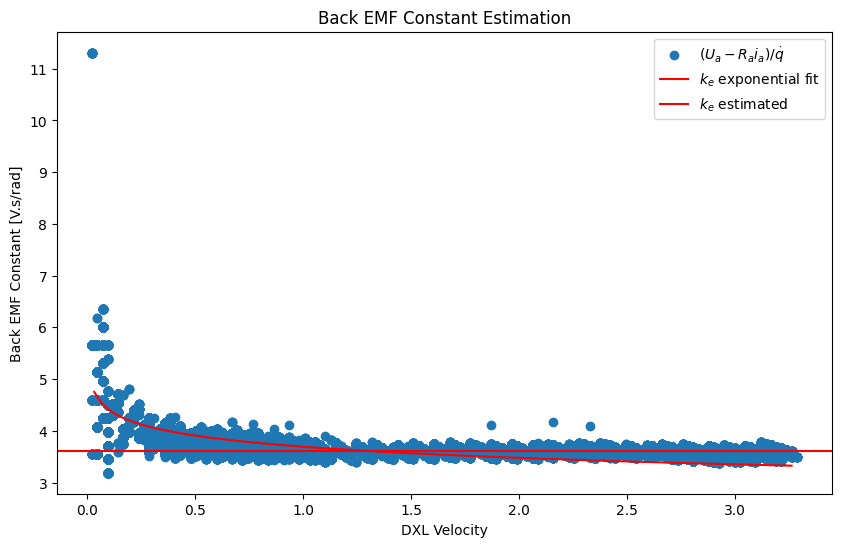

Exponential coefficient (a): 3.692371427546772
Exponential coefficient (b): -0.3105417913664852
3.6103081452089345


In [81]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Assuming 'neww_df' is your DataFrame

# Define the exponential function
def exp_func(x, a, b, c=0):
    # return a * np.exp(-b * x)
    return a+b*np.log(x)
    # return a/(1+np.exp(-b*(x-c)))

# Fit the exponential function to the data
thing = neww_df[neww_df['DXL_Velocity'] < 1.5]
params, covariance = curve_fit(exp_func, abs(thing['DXL_Velocity']), thing['ke'])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(abs(neww_df['DXL_Velocity']), neww_df['ke'], label=r"$(U_a - R_a i_a)/\dot{q}$")

# Generate x values for the exponential line
x_vals = np.linspace(0, max(neww_df['DXL_Velocity']), 100)
plt.plot(x_vals, exp_func(x_vals, *params), 'r', label=r'$k_e$ exponential fit')
plt.axhline(y=my_df['ke'].mean(), color='r', label=r'$k_e$ estimated')

plt.xlabel('DXL Velocity')
plt.ylabel('Back EMF Constant [V.s/rad]')
plt.title('Back EMF Constant Estimation')
plt.legend()
plt.show()

# Print the parameters
print(f"Exponential coefficient (a): {params[0]}")
print(f"Exponential coefficient (b): {params[1]}")
print(my_df['ke'].mean())

In [7]:
import numpy as np
plt.figure(figsize=(10, 6))
ke = 3.75286
all_experiment = all_experiments_with_transients
my_list1 = []
my_list2 = []
my_list3 = []
for df in all_experiment:
    v = (df['U'] - Ra * df['DXL_Current'])/ke
    my_list1.append(v.mean())
    my_list2.append(df['DXL_Velocity'].mean())
    
    q_i = df['DXL_Position'].iloc[0]
    q_f = df['DXL_Position'].iloc[len(df)-1]
    v_f = (q_f - q_i)/df['t'].iloc[len(df)-1]
    my_list3.append(v_f)
    # plt.plot(df['DXL_Velocity'])
    # plt.plot(v)
    # count += 1

    # plt.xlabel('Time (sample)')
    # plt.ylabel('Voltage [V]')
    # plt.title(f'Measured Voltage')
    # plt.show()

print(my_list2)
print(my_list1)
print(my_list3)

[0.002671412213291244, -0.000717829540914475, 0.047065100324301, -0.04741076028879781, 0.8184865834993131, -0.8192947006843234, 0.8555255016224038, -0.8576119898720398, 0.3053651617270097, -0.3039456074753742, 0.3358678515571172, -0.3350525489193342, 0.08073163923061383, -0.08104604666846457, 0.11783749573526721, -0.11865225824288057, 2.33155592344789, -2.3457136724494005, 2.4343427657576004, -2.4399525775022797, 0.5198437169931207, -0.5224839814212531, 0.5571510633711122, -0.5576657572006997, 2.7021106513380198, -2.715374569857558, 2.803352738413703, -2.8083493417460232, 0.15377628254164877, -0.1540517186954309, 0.19005064866815685, -0.19006825018148663, 2.5294988648122607, -2.5356771256837076, -2.6284583925019733, 2.6209078282660183, 0.6707500675726432, -0.6685794087149064, 0.7071599901068742, -0.7070210527897455, 0.5954974455129431, -0.594338371074763, 0.6315023367280455, -0.6306170230421987, 2.1735783238248705, -2.1763750900996786, 2.267629209034496, -2.273729824934209, 2.892528223

<Figure size 1000x600 with 0 Axes>

In [49]:
import numpy as np
plt.figure(figsize=(10, 6))
ke = 0.8594
all_experiment = all_experiments_with_transients
my_list1 = []
my_list2 = []
my_list3 = []
my_thth = []
for df in all_experiment:
    v = (df['U'] - Ra * df['DXL_Current'])/ke
    my_list1.append(v.mean())
    my_list2.append(df['DXL_Velocity'].mean())
    
    q_i = df['DXL_Position'].iloc[0]
    q_f = df['DXL_Position'].iloc[len(df)-1]
    v_f = (q_f - q_i)/(df['t'].iloc[len(df)-1] - df['t'].iloc[0])
    my_list3.append(v_f)

    # my_thth.append(df[100:])
    if abs(v_f) < 0.8 :
        my_thth.append(df[100:])
    #     plt.scatter(df.index, df['DXL_Current'])
    #     plt.plot(df['DXL_Position'] - q_i, label="Measured")
    #     df['q_pred'] = 0
    #     for i in range(1, len(df)):
    #         df.loc[i, 'q_pred'] = df.loc[i - 1, 'q_pred'] + df.loc[i - 1, 'DXL_Velocity'] * df.loc[i - 1, 'delta_t']
    #     plt.plot(df['DXL_Velocity'].mean() * (df['t'] - df['t'].iloc[0]), label=r"With mean of $\dot{q}_{meas}$")
    #     plt.plot(v_f * (df['t'] - df['t'].iloc[0]), label=r"With $v_{est}$")
    #     plt.plot(df['q_pred'], label=r"Numerical Derivation")
    #     plt.xlabel('Sample')
    #     plt.ylabel('Position [rad]')
    #     plt.title(f'Error Estimation on Position Evolution')
    #     plt.legend()
    #     plt.show()



        # txt = r"$v_{est} - v_{meas}= $"
        # txt = r"$error = $"
        # diff = (v_f - df['DXL_Velocity'].mean()) * 100 / v_f
        # plt.plot(df['DXL_Velocity'], label= f"{txt}{diff:.1f} %")

        # plt.plot(v)
        # count += 1


# plt.xlabel('Sample')
# plt.ylabel('Velocity [rad/s]')
# plt.title(f'Error Estimation on Measured Velocity')
# plt.legend()
# plt.show()

print(my_list2)
print(my_list1)
print(my_list3)

[0.002671412213291244, -0.000717829540914475, 0.047065100324301, -0.04741076028879781, 0.8184865834993131, -0.8192947006843234, 0.8555255016224038, -0.8576119898720398, 0.3053651617270097, -0.3039456074753742, 0.3358678515571172, -0.3350525489193342, 0.08073163923061383, -0.08104604666846457, 0.11783749573526721, -0.11865225824288057, 2.33155592344789, -2.3457136724494005, 2.4343427657576004, -2.4399525775022797, 0.5198437169931207, -0.5224839814212531, 0.5571510633711122, -0.5576657572006997, 2.7021106513380198, -2.715374569857558, 2.803352738413703, -2.8083493417460232, 0.15377628254164877, -0.1540517186954309, 0.19005064866815685, -0.19006825018148663, 2.5294988648122607, -2.5356771256837076, -2.6284583925019733, 2.6209078282660183, 0.6707500675726432, -0.6685794087149064, 0.7071599901068742, -0.7070210527897455, 0.5954974455129431, -0.594338371074763, 0.6315023367280455, -0.6306170230421987, 2.1735783238248705, -2.1763750900996786, 2.267629209034496, -2.273729824934209, 2.892528223

<Figure size 1000x600 with 0 Axes>

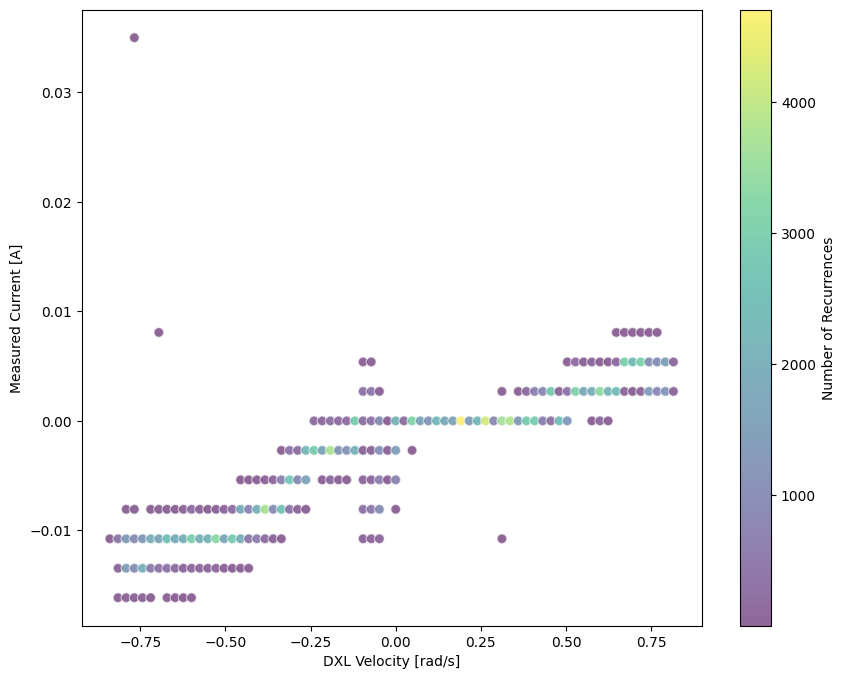

In [50]:
import pandas as pd
big_df = pd.concat(my_thth, ignore_index=True)

# Group the data by 'DXL_Velocity', 'DXL_Current', and 'U' to find the recurrence
grouped = big_df.groupby(['DXL_Velocity', 'DXL_Current']).size().reset_index(name='counts')
# mean_R = grouped['R'].mean()

# Now let's create the scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(grouped['DXL_Velocity'], grouped['DXL_Current'], c=grouped['counts'], cmap='viridis', alpha=0.6, edgecolors='w', s=50)

# plt.axhline(y=mean_R, color='r', linestyle='-', label=f'Average Current: {mean_R:.2f}')


plt.xlabel('DXL Velocity [rad/s]')
plt.ylabel('Measured Current [A]')
# plt.ylabel('kphi value [V.s/rad]')
cb = plt.colorbar(sc)
cb.set_label('Number of Recurrences')
# Adding the legend
# plt.legend()
plt.show()

In [94]:
3.4 / (353 * 1.3 * 0.7)

0.010584316533325032

In [92]:
3.61 / 353

0.010226628895184135